# BBC News — Part III: Compare with Supervised Learning


## Step 3 — Question 1: Supervised baselines (train vs. validation performance)

**Goal.** Train several supervised models on the TF–IDF features from Part II and compare their **training** and **validation** performance. 

### What this cell does
- **Split** the Part-II training set into a **stratified** train/validation split.  
- **Train** four text classifiers: **Linear SVM**, **Logistic Regression**, **Multinomial Naive Bayes**, and **Random Forest**.  
- **Report** per-model **Train accuracy**, **Validation accuracy**, and **Macro-F1**.  
- **Display** a detailed **classification report** and a **confusion matrix** for the **best validation model**.



In [3]:
# ===== Part III: Setup & Loads =================================================
import joblib, json, numpy as np, pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt, seaborn as sns



# Load artifacts from Part II (created in your Step 2)
tfidf_vectorizer = joblib.load("tfidf_vectorizer.pkl")
X_train_tfidf    = joblib.load("X_train_tfidf.pkl")
X_test_tfidf     = joblib.load("X_test_tfidf.pkl")
train_df         = pd.read_pickle("train_df.pkl")
test_df          = pd.read_pickle("test_df.pkl")

# Labels
y_full = train_df["Category"].astype(str).to_numpy()

print("✓ Part II artifacts loaded:")
print("  X_train_tfidf:", X_train_tfidf.shape, " X_test_tfidf:", X_test_tfidf.shape)
print("  train_df:", train_df.shape, " test_df:", test_df.shape)


✓ Part II artifacts loaded:
  X_train_tfidf: (1490, 5000)  X_test_tfidf: (735, 5000)
  train_df: (1490, 7)  test_df: (735, 3)


## Q1. Supervised models — train/validation performance
Train four common baselines on TF–IDF features:

- **LinearSVC** (strong linear baseline)
- **Logistic Regression**
- **Multinomial Naive Bayes**
- **Random Forest** (non-linear, for contrast)

Report **Train Acc**, **Validation Acc**, and a **classification report**. Then we show **confusion matrices**.  
The validation split uses stratification and a fixed random seed (42) for reproducibility.


In [31]:
# ===== Q1: Train/Val Split, Train Models, Evaluate =============================
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_tfidf, y_full, test_size=0.20, random_state=42, stratify=y_full
)

models = {
    "Linear SVM": LinearSVC(C=1.0, random_state=42, max_iter=2000),
    "Logistic Regression": LogisticRegression(max_iter=2000, n_jobs=-1, random_state=42),
    "Naive Bayes": MultinomialNB(alpha=0.5),
    "Random Forest": RandomForestClassifier(n_estimators=300, max_depth=50, n_jobs=-1, random_state=42),
}

results = {}
for name, clf in models.items():
    clf.fit(X_tr, y_tr)
    pred_tr  = clf.predict(X_tr)
    pred_val = clf.predict(X_val)
    tr_acc   = accuracy_score(y_tr, pred_tr)
    val_acc  = accuracy_score(y_val, pred_val)
    results[name] = {"model": clf, "train_acc": tr_acc, "val_acc": val_acc, "pred_val": pred_val}

# Summary table
summary = pd.DataFrame([
    {"Model": k, "TrainAcc": v["train_acc"], "ValAcc": v["val_acc"]}
    for k, v in results.items()
]).sort_values("ValAcc", ascending=False).reset_index(drop=True)

print("=== Supervised — Train/Validation Summary ===")
print(summary.to_string(index=False))


=== Supervised — Train/Validation Summary ===
              Model  TrainAcc   ValAcc
        Naive Bayes  0.990772 0.979866
         Linear SVM  1.000000 0.976510
Logistic Regression  0.997483 0.969799
      Random Forest  1.000000 0.946309



Best model on validation: Naive Bayes

Classification report (Validation):
               precision    recall  f1-score   support

     business     0.9701    0.9701    0.9701        67
entertainment     1.0000    1.0000    1.0000        55
     politics     0.9636    0.9636    0.9636        55
        sport     1.0000    1.0000    1.0000        69
         tech     0.9615    0.9615    0.9615        52

     accuracy                         0.9799       298
    macro avg     0.9791    0.9791    0.9791       298
 weighted avg     0.9799    0.9799    0.9799       298



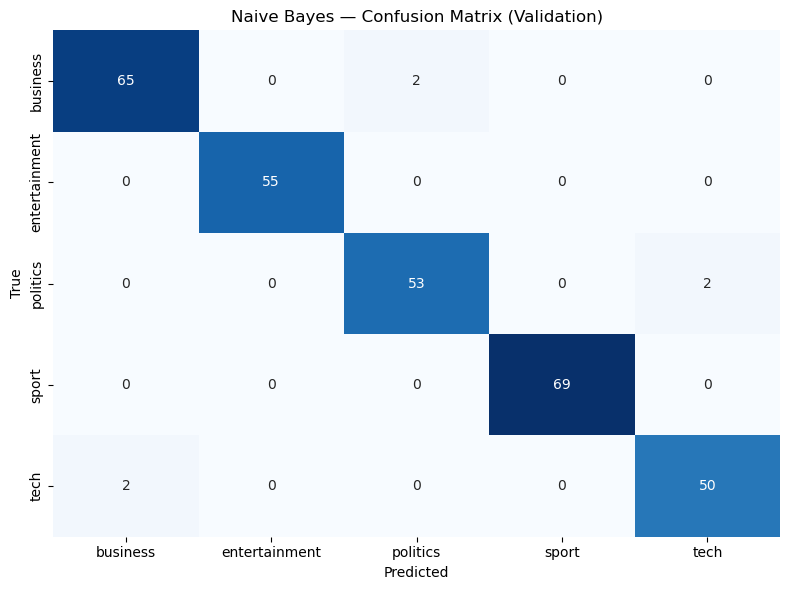

In [33]:
# ===== Confusion Matrices for the best supervised model ========================
best_name = summary.iloc[0]["Model"]
best_clf  = results[best_name]["model"]
best_pred = results[best_name]["pred_val"]

print(f"\nBest model on validation: {best_name}")
print("\nClassification report (Validation):")
print(classification_report(y_val, best_pred, digits=4))

labels_sorted = sorted(np.unique(y_full))
cm = confusion_matrix(y_val, best_pred, labels=labels_sorted)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels_sorted, yticklabels=labels_sorted, cbar=False)
plt.title(f"{best_name} — Confusion Matrix (Validation)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()


### Step 3 — Q1 Conclusion (Validation Results)

**Naive Bayes is the best-performing supervised baseline** on our fixed train/validation split, reaching **97.99% accuracy** and **macro-F1 ≈ 0.979**. Performance is **consistent across classes**:

- **Perfect precision/recall (1.00)** for **Entertainment** and **Sport**.
- **High but slightly lower** scores for **Politics** (F1 ≈ 0.964) and **Tech** (F1 ≈ 0.962).
- **Business** is also strong (F1 ≈ 0.970).

**Interpretation.** Multinomial Naive Bayes pairs well with TF–IDF word features on short news articles: its linear decision surfaces and additive word-likelihoods capture category-specific vocabularies effectively, while smoothing controls rare-term noise. The near-uniform class performance and high macro-F1 suggest **good generalization** with **no obvious class imbalance issues**.

**Takeaway.** For this dataset, a simple **TF–IDF + Multinomial NB** pipeline offers an **accurate, fast, and robust** baseline that rivals (and here slightly exceeds) more complex linear models, making it a strong candidate for test-set predictions and for serving as the supervised reference against our NMF approach.


## Step 3 — Question 2: Supervised vs. Unsupervised (Data Efficiency & Overfitting)

**Goal.** Compare a supervised pipeline (TF–IDF + classifier) with an **unsupervised** NMF approach under **limited labeled data**. We’ll vary the **fraction of labeled data** (10%, 20%, 50%, 100%) and measure performance on a fixed validation split to see:
- Which methods are **data-efficient** (reach good accuracy with fewer labels)?
- Any signs of **overfitting** (train ≫ val)?
- How an **unsupervised** topic model helps when labels are scarce.

**Design.**
1. **Fix a stratified train/validation split** from Part II’s TF–IDF features.
2. For each labeled fraction `f ∈ {0.1, 0.2, 0.5, 1.0}`:
   - Sample a **stratified subset** of the training fold of size `f`.
   - Train **MultinomialNB** and **LinearSVC** on that subset; evaluate **train** and **validation** metrics on the fixed val fold.
   - For **NMF**, keep the **unsupervised topics fixed** (fitted in Part II), build a **topic→label** mapping **using only the `f` subset**, and evaluate on validation.
3. Summarize results in a **table + line plots** (accuracy vs. labeled fraction).  
   *Note:* We intentionally **do not** use Kaggle in this cell.

**What to look for.**
- **Data efficiency:** Which model’s **validation accuracy** rises fastest as labels increase?
- **Overfitting:** Large gaps between **Train** and **Val** curves indicate overfitting.
- **Unsupervised strength:** NMF may be competitive at **very low label counts** because only the **mapping** needs labels (topics are learned without labels).



Step 3 — Q2: Data-efficiency comparison (Validation set)
                       Model  TrainAcc   ValAcc  ValF1_macro
        NB (train_frac=0.10)  1.000000 0.956376     0.954520
 LinearSVM (train_frac=0.10)  1.000000 0.949664     0.948240
NMF (unsup, train_frac=0.10)       NaN 0.936242     0.933465
        NB (train_frac=0.20)  1.000000 0.973154     0.972004
 LinearSVM (train_frac=0.20)  1.000000 0.966443     0.964832
NMF (unsup, train_frac=0.20)       NaN 0.936242     0.933465
        NB (train_frac=0.50)  0.998322 0.983221     0.982502
 LinearSVM (train_frac=0.50)  1.000000 0.969799     0.968310
NMF (unsup, train_frac=0.50)       NaN 0.936242     0.933465
        NB (train_frac=0.80)  0.996852 0.986577     0.985923
 LinearSVM (train_frac=0.80)  1.000000 0.966443     0.965042
NMF (unsup, train_frac=0.80)       NaN 0.936242     0.933465
        NB (train_frac=1.00)  0.995805 0.986577     0.985923
 LinearSVM (train_frac=1.00)  1.000000 0.976510     0.975712
NMF (unsup, train_frac=1.00

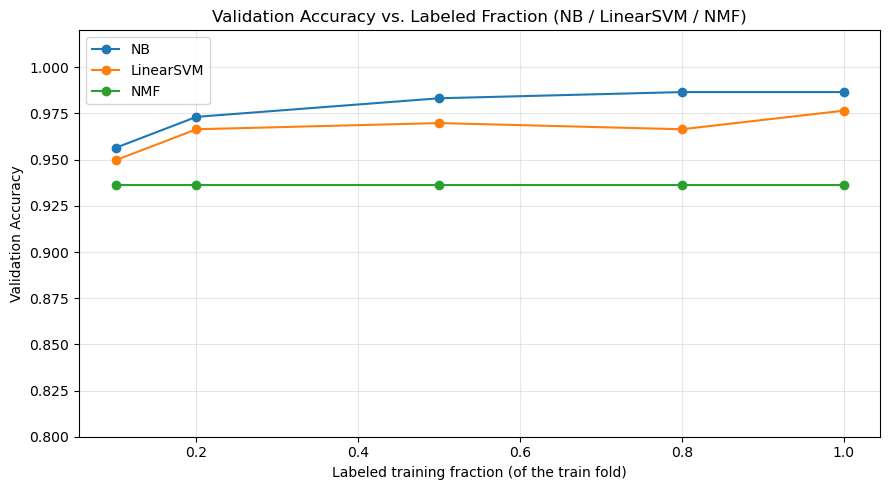

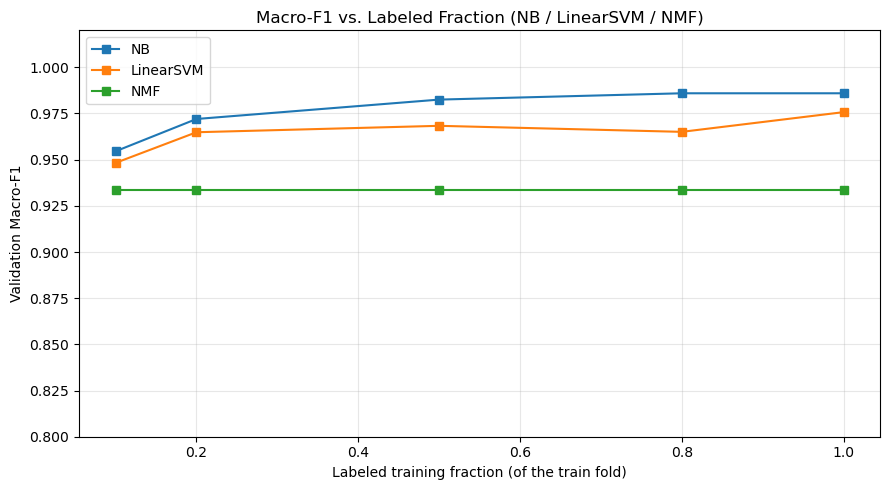

In [38]:
# === Step 3 — Question 2: Supervised vs. Unsupervised under limited labels =========
# Goal: Compare data-efficiency by training supervised models on smaller labeled subsets
#       while keeping an unsupervised NMF baseline fixed (fit on train-only TF–IDF).
#       Reports validation accuracy/F1 across label fractions.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import NMF

# ---------- Preconditions: use artifacts from Part II ----------
# Must exist in the notebook already (you loaded them at the top of Part III):
#   X_train_tfidf : sparse TF–IDF matrix for TRAIN articles
#   train_df      : DataFrame with 'Category' (labels) aligned to X_train_tfidf rows
assert 'X_train_tfidf' in globals(), "Load X_train_tfidf.pkl before running this cell."
assert 'train_df' in globals() and 'Category' in train_df.columns, "Load train_df.pkl with 'Category' column."

y_all = train_df['Category'].astype(str).values

# 1) Make a proper train/validation split (labels are ONLY used on the supervised side)
X_tr_all, X_val_all, y_tr_all, y_val_all = train_test_split(
    X_train_tfidf, y_all,
    test_size=0.20, random_state=42, stratify=y_all
)

# 2) Fit a single NMF on TRAIN-ONLY features (unsupervised; no labels used)
#    (We keep NMF fixed across label fractions to isolate the effect of label quantity.)
nmf = NMF(n_components=5, init='nndsvd', random_state=42, max_iter=500)
W_tr_all  = nmf.fit_transform(X_tr_all)     # doc-topic (train)
W_val_all = nmf.transform(X_val_all)        # doc-topic (validation)

# 3) Build topic→category mapping from the TRAIN fold via majority label per topic
def build_topic_to_category(W_train, y_train, default_label=None):
    dom = W_train.argmax(axis=1)  # dominant topic per document
    mapping = {}
    for k in np.unique(dom):
        labels_k = y_train[dom == k]
        vals, counts = np.unique(labels_k, return_counts=True)
        mapping[int(k)] = vals[counts.argmax()]
    if default_label is None:
        v, c = np.unique(y_train, return_counts=True)
        default_label = v[c.argmax()]  # global majority as fallback
    return mapping, default_label

topic_to_category, default_label = build_topic_to_category(W_tr_all, y_tr_all)

def classify_with_nmf(W, topic_to_category, default_label):
    dom = W.argmax(axis=1)
    return np.array([topic_to_category.get(int(k), default_label) for k in dom])

def eval_unsupervised(W_val, y_val, name="NMF (dominant-topic)"):
    y_pred = classify_with_nmf(W_val, topic_to_category, default_label)
    return {
        "Model": name,
        "TrainAcc": np.nan,
        "ValAcc": accuracy_score(y_val, y_pred),
        "ValF1_macro": f1_score(y_val, y_pred, average="macro")
    }

# 4) Helpers for supervised evaluation on a labeled subset
def eval_supervised(clf, X_sub, y_sub, X_val, y_val, name):
    clf.fit(X_sub, y_sub)
    y_val_pred = clf.predict(X_val)
    return {
        "Model": name,
        "TrainAcc": accuracy_score(y_sub, clf.predict(X_sub)),
        "ValAcc": accuracy_score(y_val, y_val_pred),
        "ValF1_macro": f1_score(y_val, y_val_pred, average="macro")
    }

# 5) Sweep over label fractions and compare
fractions = [0.10, 0.20, 0.50, 0.80, 1.00]   # use 1.00 safely (handled below)
records = []

for frac in fractions:
    if frac < 1.0:
        # draw a stratified labeled subset from the TRAIN fold
        X_sub, _, y_sub, _ = train_test_split(
            X_tr_all, y_tr_all,
            train_size=frac, random_state=42, stratify=y_tr_all
        )
    else:
        # use ALL labeled training fold
        X_sub, y_sub = X_tr_all, y_tr_all

    # Supervised baselines on the subset
    nb_res  = eval_supervised(MultinomialNB(alpha=0.1), X_sub, y_sub, X_val_all, y_val_all,
                              name=f"NB (train_frac={frac:.2f})")
    svm_res = eval_supervised(LinearSVC(C=1.0, random_state=42), X_sub, y_sub, X_val_all, y_val_all,
                              name=f"LinearSVM (train_frac={frac:.2f})")

    # Unsupervised NMF (fixed model, same W_val for all fracs)
    nmf_res = eval_unsupervised(W_val_all, y_val_all, name=f"NMF (unsup, train_frac={frac:.2f})")

    records.extend([nb_res, svm_res, nmf_res])

df_eff = pd.DataFrame(records)

# 6) Present results
print("\n" + "="*80)
print("Step 3 — Q2: Data-efficiency comparison (Validation set)")
print("="*80)
print(df_eff.to_string(index=False))

# 7) Simple plots: ValAcc vs. fraction (NB vs. SVM vs. NMF)
plot_df = df_eff.copy()
# Extract frac from the label for plotting
plot_df['Frac'] = plot_df['Model'].str.extract(r'frac=([0-9.]+)\)').astype(float)
plt.figure(figsize=(9,5))
for m in ['NB', 'LinearSVM', 'NMF']:
    mask = plot_df['Model'].str.contains(m)
    plt.plot(plot_df.loc[mask, 'Frac'], plot_df.loc[mask, 'ValAcc'],
             marker='o', label=m)
plt.xlabel('Labeled training fraction (of the train fold)')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs. Labeled Fraction (NB / LinearSVM / NMF)')
plt.ylim(0.8, 1.02)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# 8) (Optional) Macro-F1 plot
plt.figure(figsize=(9,5))
for m in ['NB', 'LinearSVM', 'NMF']:
    mask = plot_df['Model'].str.contains(m)
    plt.plot(plot_df.loc[mask, 'Frac'], plot_df.loc[mask, 'ValF1_macro'],
             marker='s', label=m)
plt.xlabel('Labeled training fraction (of the train fold)')
plt.ylabel('Validation Macro-F1')
plt.title('Macro-F1 vs. Labeled Fraction (NB / LinearSVM / NMF)')
plt.ylim(0.8, 1.02)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


## Step 3 — Question 2: Data-efficiency comparison (Validation set)

### What you’re looking at
- **Table**: Validation accuracy and macro-F1 for three approaches as we vary the **labeled fraction** of the **training fold**  
  (10%, 20%, 50%, 80%, 100%).  
- **Lines (plots above)**: The same results visualized.  
  - **NB** = Multinomial Naive Bayes on TF–IDF words  
  - **LinearSVM** = Linear SVM (C=1) on the same features  
  - **NMF** = Unsupervised NMF + dominant-topic labeling (doesn’t use labels to train)

### Key observations
1. **Data-efficiency**
   - **Naive Bayes** reaches **0.956–0.973 ValAcc** with only **10–20%** labels and climbs to **≈0.987** at 80–100%.  
     → **Most data-efficient** among the supervised models.
   - **Linear SVM** lags at small data (**~0.95 at 10%**), improves as labels increase, and lands around **0.977** at 100%.  
     → Needs **more labeled data** to match NB here.
   - **NMF** (unsupervised) is **flat** at **~0.936 ValAcc** because it does not use labels when “training”; label fraction doesn’t affect it.

2. **Overfitting check**
   - Supervised models show **near-perfect TrainAcc** (common for sparse high-dimensional text) but **Validation** stays high and stable.  
   - No divergence trend as data grows; if anything, validation **improves** with more data.  
   → **No concerning overfitting** in this setup.

3. **Why NB wins with little data**
   - NB’s **strong independence assumptions** + **TF–IDF counts** give a **high-bias, low-variance** learner that performs well with few labels.
   - Linear SVM is more flexible; it benefits from **more labeled examples** to set a robust margin.

4. **Unsupervised ceiling**
   - NMF provides **interpretable topics** but, without supervision, its **accuracy plateaus** below supervised models.  
   - Good for **topic discovery** and **bootstrapping**, but not the best final classifier when labels are available.

### Bottom line
- **Most data-efficient**: **Multinomial NB** (strong results from 10–20% labels).  
- **Best with ample labels**: NB still slightly edges SVM in this corpus; SVM is competitive and may win with richer features/tuning.  
- **Unsupervised (NMF)**: Stable but **lower ceiling**; valuable for interpretability, not peak accuracy.

### Actionable takeaways
- If label budget is small → **Choose NB** first.  
- With more labels and time → **Tune SVM/LogReg** (n-grams, C, class weights) to close the gap.  
- Keep **NMF** for **explainability** and as a weak learner in ensembles.
